# Исследование eCPM

### Постановка задачи

Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров.

**План исследования:**
- Обзор и предобработка данных
- Построение распределения средних eCPM-ов юзеров
- Отображение средних eCPM-ов по городам, версиям ОС
- ANOVA и Tukey-test по городам
- Отображение суммарных доходов по городам, версиям ОС
- Вывод

#### Обзор данных

Импортируем необходимые библиотеки

In [27]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statsmodels.stats.multicomp import pairwise_tukeyhsd
np.set_printoptions(suppress=True) ;

Подгружаем данные и отображаем общую информацию

In [2]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

Сразу можно обнаружить следующие проблемы в данных:
- Есть несколько пропусков в столбце с id пользователя (от этих строк избавимся, ведь восстановить их не получится и данных мы потеряем минимальное количество)
- Есть пропуски в столбце с названием оператора (удалим этот столбец, над ним не планируется проводить никаких манипуляций)
- Есть много пропусков в названии города. Предположу, что у пользователя есть опция указать город в процессе регистрации и часть пользователей этого не делают. Пока что оставим пропуски в этом столбце как есть, ведь удаление такого значительного количества строк приведет к сильному обеднению датасета, а возможный способ восстановления пока не очевиден.
- Неверные типы данных в столбцах с датами и временем. Необходимо преобразовать в datetime

- *Также отдельно стоит упомянуть необходимость извлечь данные из колонки json и создать для них отдельные столбцы для удобства работы с этими данными*

P.S. Явные дубликаты отсутствуют, страна действительно только США, лишние данные в датасет не попали

#### Предобработка данных

In [3]:
df = df.dropna(subset=['profile_id']) # удаляем строки, в которых не указан айди юзера
df = df.drop('operator_name', axis=1) # удаляем столбец с именем оператора

# преобразуем столбцы с датой в тип datetime
df['event_datetime'] = pd.to_datetime(df['event_datetime']) 
df['event_receive_datetime'] = pd.to_datetime(df['event_receive_datetime'])

In [4]:
#сравниваем количество записей о пользователе с числом упоминаний города в этих записях
city_nan_check = df.groupby('profile_id').agg({'city':['count', 'size', 'nunique']}).reset_index()
# выводим на экран полученный датафрейм, а также тех пользователей, для которых указано 2 и более городов
display(city_nan_check.head(), city_nan_check[city_nan_check['city']['nunique']>1].head(3))

profile_id  city             
               count size nunique
0  JL00qCZH1HV     0   13       0
1  JL015rw9vmN   371  429       2
2  JL01aCdFTJy    39   39       1
3  JL04ODuw9UP    84   84       1
4  JL06OWhBYxn    13   13       1

profile_id  city             
                count size nunique
1   JL015rw9vmN   371  429       2
23  JL0u6mnAMTV    31   31       2
25  JL0vB2rdkeV   112  112       3

Видим, что существуют такие пользователи, у которых однажды указан город и по нему потенциально можно восстановить пропущенные значения в остальных строчках. Однако есть пользователи, которые заходят в игру из разных мест. 
В ячейке ниже можно увидеть, что пользователь заходит в игру через wifi из города Lima, а через cell из двух разных городов. Это может стать препятствием. Стоит уточнить у заказчика, каким образом формируется этот столбец и есть ли возможность восстановить пропуски таким образом.

In [5]:
# выберем одного такого пользователя и посмотрим, как он оказывается в разных городах
df[df['profile_id'] == 'JL0vB2rdkeV'][['connection_type', 'city']].sample(10)

,connection_type,city
23374,cell,Cincinnati
23380,cell,Cincinnati
23388,cell,Cincinnati
23005,cell,Dayton
518114,wifi,Lima
518106,wifi,Lima
23003,cell,Dayton
23385,cell,Cincinnati
22991,cell,Dayton
22987,cell,Dayton


Извлечём данные из json и добавим в новые колонки для дальнейшего исследования.

In [6]:
def add_column_from_json(json_file, column_name):
    """Функция подгружает json и по заданному ключу (column_name) возвращает значение 
    для нового создаваемого столбца"""
    value_from_json = json.loads(json_file)[column_name]
    return value_from_json

#применяем функцию к необходимым ключам в json
df['revenue'] = df.event_json.apply(add_column_from_json, args=['revenue']) 
df['ad_type'] = df.event_json.apply(add_column_from_json, args=['ad_type'])
df['ads_ltv'] = df.event_json.apply(add_column_from_json, args=['ads_ltv'])
df['ecpm'] = df['revenue'] * 1000 # вычислим eCPM как revenue * 1000

In [7]:
def drop_outliers(data, column):
    """Функция оставляет в заданной колонке column датафрейма data значения,
    входящие в пределы (q1 - 1.7iqr, q3 + 1.7iqr)"""
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1
    data = data.query(f'{column} < {q3 + 1.7 * iqr} and {column} > {q1 - 1.7 * iqr}')
    return data

### 1. a) Построение распределений средних eCPM юзеров

Сгруппируем данные по типу рекламы и пользователю и вычислим средний eCPM для каждого пользователя.

In [8]:
# сгруппируем данные по типу объявления и айди и посчитаем для каждого айди средний eCPM
mean_ecpm_by_adtype = df.groupby(['ad_type', 'profile_id']).agg({'ecpm':'mean'}).reset_index()

# сделаем для каждого типа объявления свой датафрейм
full = mean_ecpm_by_adtype.query('ad_type=="int"')
rv = mean_ecpm_by_adtype.query('ad_type=="rv"')
banner = mean_ecpm_by_adtype.query('ad_type=="banner"')

mean_ecpm_by_adtype.head()

,ad_type,profile_id,ecpm
0,banner,JL00qCZH1HV,3.183940
1,banner,JL015rw9vmN,1.160748
2,banner,JL01aCdFTJy,0.740097
3,banner,JL04ODuw9UP,0.213227
4,banner,JL06OWhBYxn,0.468146


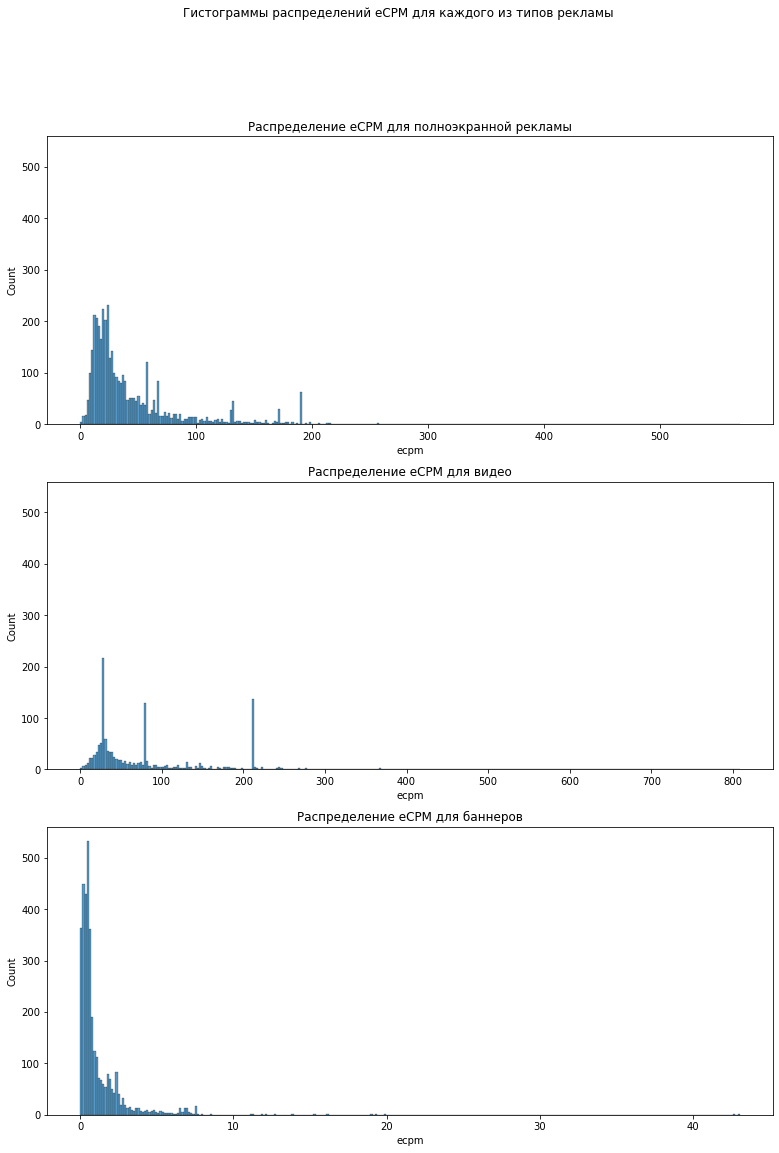

In [9]:
# построим гистограмму для каждого типа объявлений
bins = 300
fig, ax = plt.subplots(3, 1, figsize=(13,18), sharey=True)
fig.suptitle('Гистограммы распределений eCPM для каждого из типов рекламы')
sns.histplot(data=full, bins=bins, x='ecpm', ax=ax[0])
ax[0].set_title('Распределение eCPM для полноэкранной рекламы')
sns.histplot(data=rv, bins=bins, x='ecpm', ax=ax[1])
ax[1].set_title('Распределение eCPM для видео')
sns.histplot(data=banner, bins=bins, x='ecpm', ax=ax[2])
ax[2].set_title('Распределение eCPM для баннеров')
plt.show()

In [10]:
# посмотрим описательную статистику для каждого типа
display(full.describe(), rv.describe(), banner.describe())

,ecpm
count,3962.000000
mean,45.557457
std,46.877344
min,0.000000
25%,17.620615
50%,27.623670
75%,56.397665
max,568.678270


,ecpm
count,1324.000000
mean,80.502004
std,79.154906
min,0.223222
25%,28.240000
50%,46.019935
75%,98.067206
max,808.294820


,ecpm
count,3508.000000
mean,1.157111
std,1.867792
min,0.013930
25%,0.322804
50%,0.583002
75%,1.297329
max,43.021387


Как визуально, так и с помощью описательных статистик видим, что распределения смещены вправо. Видимо, это происходит из-за длинного "хвоста" из выбросов. Воспользуемся стандартным способом избавления от выбросов через интерквартильный размах.

In [11]:
# избавимся от выбросов
full = drop_outliers(full, 'ecpm')
rv = drop_outliers(rv, 'ecpm')
banner = drop_outliers(banner, 'ecpm')

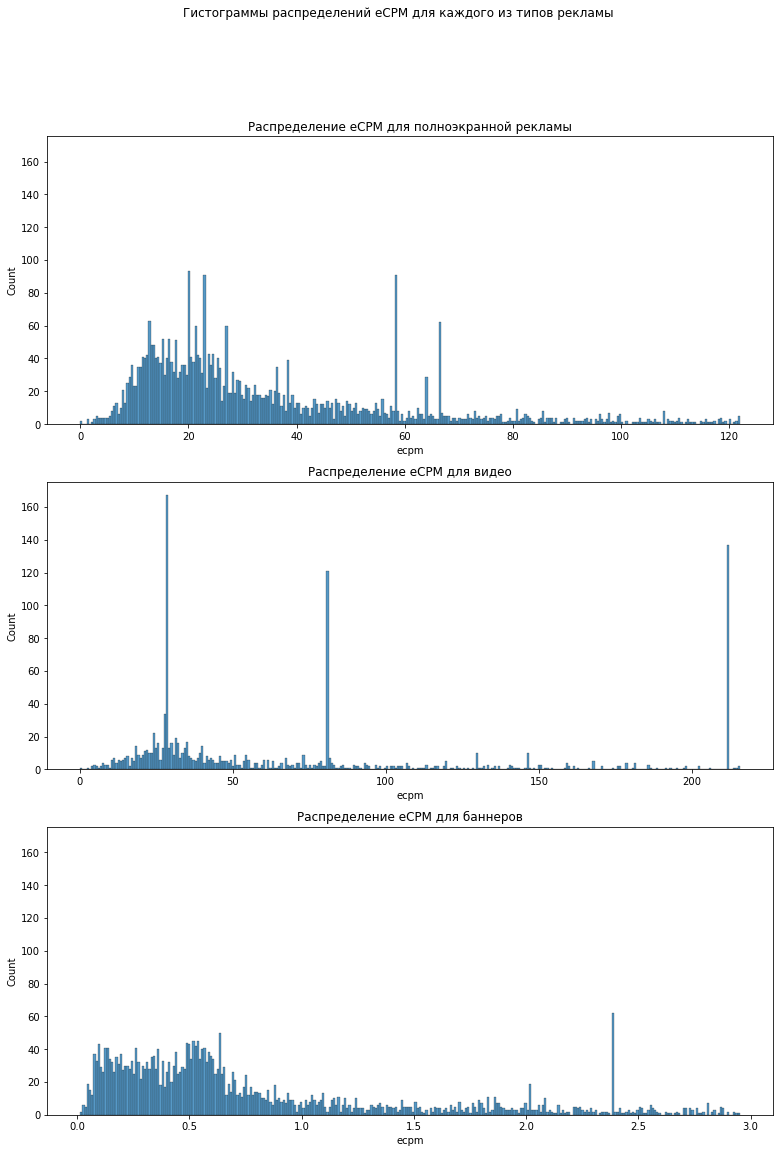

In [12]:
# повторим визуализацию 
fig, ax = plt.subplots(3, 1, figsize=(13,18), sharey=True)
fig.suptitle('Гистограммы распределений eCPM для каждого из типов рекламы')
sns.histplot(data=full, bins=bins, x='ecpm', ax=ax[0])
ax[0].set_title('Распределение eCPM для полноэкранной рекламы')
sns.histplot(data=rv, bins=bins, x='ecpm', ax=ax[1])
ax[1].set_title('Распределение eCPM для видео')
sns.histplot(data=banner, bins=bins, x='ecpm', ax=ax[2])
ax[2].set_title('Распределение eCPM для баннеров')
plt.show()

In [13]:
# повторим вывод описательных статистик
display(full.describe(), rv.describe(), banner.describe())

,ecpm
count,3633.000000
mean,34.136346
std,24.088901
min,0.000000
25%,16.711899
50%,25.434385
75%,45.884331
max,121.984368


,ecpm
count,1283.000000
mean,72.682765
std,62.580217
min,0.223222
25%,28.240000
50%,43.384727
75%,84.437353
max,215.556600


,ecpm
count,3238.000000
mean,0.773588
std,0.676418
min,0.013930
25%,0.299887
50%,0.548162
75%,0.991169
max,2.952090


<b>Промежуточный вывод по шагу 1а):</b><br>
От самых сильных выбросов мы избавились, но распределения всё ещё смещены вправо. На каждой из гистограмм присутствуют пики, самые значительные из них — на гистограмме распределения eCPM-ов для видео<br>
Наибольший eCPM, средний и медианный, имеют видео (однако, видео также имеют и наибольшее стандартное отклонение), на втором месте полноэкранные объявления, а наименьший eCPM у баннеров.<br>

### 1. б) Отображение средних eCPM по городу, версии ОС

<b>Комментарий:</b> в ТЗ не очевидным образом отражен желаемый результат по шагам б) и в). Не до конца понятно, нужно исследовать средние eCPM по городам <b>и</b> версиям ОС или требуется исследовать их по отдельности. Я принял решение сделать второе, однако двухфакторный анализ тоже возможно реализовать.

Составим сводную таблицу для средних значений по городу в зависимости от типа объявления. Такую же таблицу составим для версии ОС. Пропуски заполним нулями, ведь никакого eCPM для этого источника нет.

In [14]:
mean_ecpm_by_city = pd.pivot_table(data=df, index='city', columns='ad_type', values='ecpm').fillna(0)
mean_ecpm_by_os = pd.pivot_table(data=df, index='os_version', columns='ad_type', values='ecpm').fillna(0)

In [15]:
# выведем размерности каждого из датафреймов
display(mean_ecpm_by_city.shape, mean_ecpm_by_os.shape)

(920, 3)

(11, 3)

In [16]:
mean_ecpm_by_city.head()

ad_type,banner,int,rv
city,,,
Aberdeen,0.321518,13.583285,21.516378
Abilene,0.941283,50.301282,53.492880
Addison,0.142235,0.000000,0.000000
Afton,0.303306,29.088757,0.000000
Akron,0.389318,64.626718,184.032872


(74, 2)


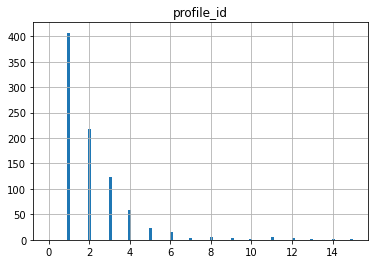

In [17]:
# посчитаем число уникальных пользователей на один город
unique_per_city = df.groupby('city').agg({'profile_id':'nunique'}).reset_index()
# выведем число городов, в которых больше 7 пользователей
print(unique_per_city[unique_per_city.profile_id >= 7].shape)
# визуализируем на гистограмме как убывает число уникальных пользователей
unique_per_city.hist(bins=100, range=(0, 15));

Судя по размерностям, с визуализацией eCPM-ов по версии ОС проблем не возникнет. А вот 920 уникальных городов наглядно визуализировать сложно. Придётся отбирать наиболее значимые. Для этого необходимо произвести дисперсионный анализ (one-way ANOVA).
Для этого будем проверять гипотезы.<br>
- **Нулевая гипотеза:** все города приносят одинаковое количество eCPM.
- **Альтернативная гипотеза:** хотя бы одна пара городов стат.значимо отличается друг от друга по среднему eCPM

В большинстве городов из датасета записано от 1 до 7 уникальных пользователей. При этом есть длинный хвост из 74 городов, в которых уникальных пользователей не менее 7. Предпочтительнее было бы работать с городами, в которых число юзеров позволяет не полагаться на пользовательское поведение конкретного человека. Выберем города с числом уникальных пользователей не менее 30. Таких городов в нашем датасете 22.

In [18]:
# создадим список городов с числом уникальных юзеров не меньше 30
popular_cities = unique_per_city[unique_per_city.profile_id >= 30].city.values.tolist()
# выберем баннеры для первого исследования
banner = df.query('ad_type == "banner"')

# добавим подмножества eCPM для каждого из городов в списке в отдельный список
ecpm_by_pop_city = []
for city in popular_cities:
    ecpm_by_pop_city.append(banner['ecpm'][banner['city']==city])

# сохраним pvalue после ANOVA в переменную для дальнейшего post-hoc
pvalue = st.f_oneway(*ecpm_by_pop_city).pvalue

In [19]:
# применим поправку Бонферрони, чтобы учесть множественные сравнения
bonferroni_alpha = len(popular_cities)*(len(popular_cities)-1)/2
new_alpha = 0.05 / bonferroni_alpha

if pvalue < new_alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Принимаем нулевую гипотезу")

Отвергаем нулевую гипотезу


Поскольку Бонферрони является довольно консервативным ограничителем, тот факт, что стат.значимые различия в одной из пар всё же нашлись, говорит о том, что можно с большой степенью уверенности говорить о различиях минимум в одной из пар самых популярных по числу юзеров городов.

Посмотрим, какие именно города различаются по eCPM, используя post-hoc критерий Тьюки

In [20]:
# заносим eCPMы и названия городов в одномерный список (Тьюки-тест принимает только в таком виде)
data_1d = banner['ecpm'][banner.city.isin(popular_cities)].values.tolist()
groups_1d = banner['city'][banner.city.isin(popular_cities)].values.tolist()

tukey_test = pairwise_tukeyhsd(data_1d, groups_1d, alpha=0.05)

In [21]:
print(tukey_test)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     Atlanta       Austin  -0.1611  0.001 -0.2728 -0.0494   True
     Atlanta       Boston  -0.3536  0.001 -0.4661 -0.2411   True
     Atlanta    Charlotte   0.0135    0.9 -0.0861   0.113  False
     Atlanta      Chicago  -0.1804  0.001 -0.2812 -0.0796   True
     Atlanta    Cleveland    0.516  0.001  0.4104  0.6216   True
     Atlanta     Columbus   0.0458    0.9 -0.0602  0.1518  False
     Atlanta       Dallas   0.2235  0.001  0.1172  0.3297   True
     Atlanta       Denver  -0.0254    0.9  -0.131  0.0803  False
     Atlanta      Detroit  -0.2182  0.001 -0.3369 -0.0995   True
     Atlanta      Houston   0.1691  0.001    0.07  0.2681   True
     Atlanta Indianapolis   0.7108  0.001   0.607  0.8146   True
     Atlanta  Kansas City   0.0925 0.1612 -0.0113  0.1963  False
     Atlanta  Los Angeles

Видим, что большинство отобранных нами городов попарно стат.значимо различаются по показателю eCPM для баннеров. <br>
В приложенном файле tukey.txt приводится попарное сравнение средних eCPMов по баннерам из всех городов из нашего датасета по критерию Тьюки. <br><br>
Из-за ограничения по времени выполнения задания прокомментирую, что аналогичным образом я бы сравнивал остальные типы объявлений. Средние eCPM по каждому типу объявления для каждого города приводятся в датафрейме mean_ecpm_by_city выше.

Визуализируем в виде тепловой карты средние eCPM по версии ОС и типу объявления.

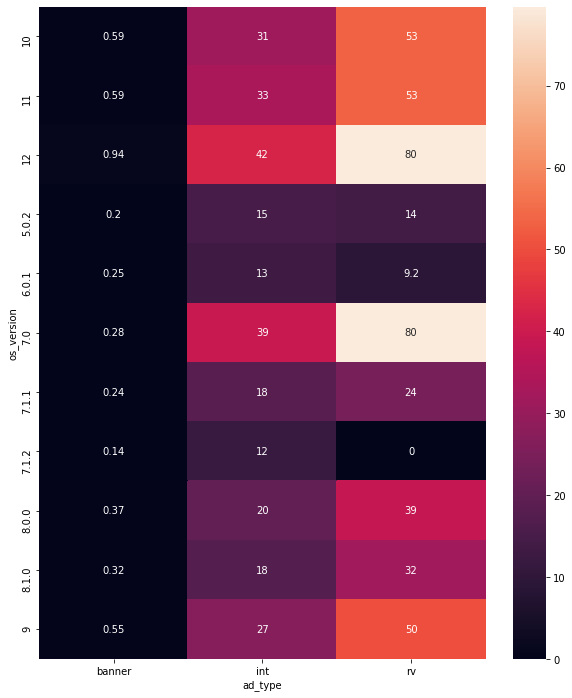

In [22]:
figure = plt.figure(figsize=(10, 12))
sns.heatmap(mean_ecpm_by_os, annot=True);

На графике видим, что наибольшие eCPM у версий 7.0, 10, 11 и 12. Самые низкие eCPM у версий 5.0.2, 6.0.1, 7.1.2 и 7.1.1. Предполагаю, что если провести тесты, которые мы провели выше, мы увидим стат.значимые различия между этими двумя группами версий ОС.

### 1. в) Отображение суммарных доходов по городу, версии ОС.

Поскольку для каждого пользователя мы имеем накопительный ltv, который с течением времени не может снижаться, есть смысл для каждого пользователя в каждом городе/для каждой ОС взять последний по времени доступный ltv и именно его учесть в суммарном доходе. <br>
Ещё один вариант, более простой, — для каждого пользователя взять максимальный ltv, именно он и окажется последним по времени.

In [23]:
# группируем по городу, профилю и типу объявления и получаем максимальные ltv
ltv_by_city = df.groupby(['city', 'profile_id', 'ad_type'], as_index=False).agg({'ads_ltv':'max'})

#суммируем ltv в каждом городе в зависимости от типа объявления
ltv_by_city = ltv_by_city.groupby(['city', 'ad_type'], as_index=False).agg({'ads_ltv':'sum'}).fillna(0)

#переформатируем результат в сводную таблицу для удобства чтения
ltv_by_city_pivot = pd.pivot_table(ltv_by_city, index='city', columns='ad_type', values='ads_ltv')

In [36]:
# выводим топ-5 городов, сортируя по 3м типам сразу
ltv_by_city_pivot.sort_values(by = ['banner', 'int', 'rv'], ascending = False).head()

ad_type,banner,int,rv
city,,,
Minneapolis,59.467911,56.815507,31.712328
New York,55.855177,52.885603,32.258305
Houston,52.913026,48.716424,29.360601
Indianapolis,49.342610,47.698915,33.967805
Denver,45.062033,39.283110,17.416381


Первая пятерка городов, как и ожидалось, состоит из больших городов с большим количеством пользователей. В зависимости от типа объявления их порядок в списке может варьироваться, однако можно говорить о том, что больше всего дохода в сумме принесли Миннеаполис, Нью Йорк, Хьюстон, Индианаполис и Денвер.

In [31]:
# группируем по ОС, профилю и типу объявления и получаем максимальные ltv
ltv_by_os = df.groupby(['os_version', 'profile_id', 'ad_type'], as_index=False).agg({'ads_ltv':'max'})

#суммируем ltv в каждой ОС в зависимости от типа объявления
ltv_by_os = ltv_by_os.groupby(['os_version', 'ad_type'], as_index=False).agg({'ads_ltv':'sum'}).fillna(0)

#переформатируем результат в сводную таблицу для удобства чтения
ltv_by_os_pivot = pd.pivot_table(ltv_by_os.fillna(0), index='os_version', columns='ad_type', values='ads_ltv')

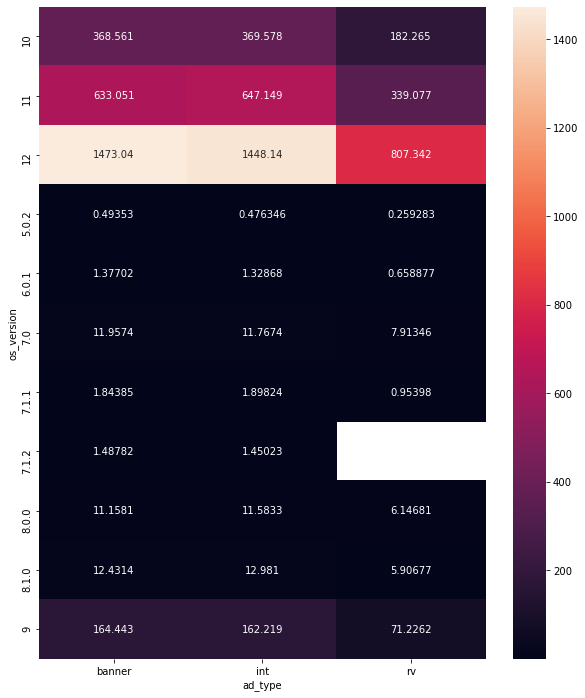

In [32]:
# визуализируем результат на тепловой карте для удобства интерпретации
fig = plt.figure(figsize=(10, 12))
sns.heatmap(ltv_by_os_pivot, annot=True, fmt='g');

По версиям операционных систем тоже есть очевидные лидеры — это версии 12, 11 и 10 (в порядке убывания дохода). Пользователи версии 7.1.2 совсем не смотрели видео. Возможно в версии игры для их ОС эта опция не предлагалась, либо те 2 уникальных пользователя, которые пользуются этой ОС, её не использовали.

## Вывод

Мы получили датасет, который содержит информацию о показах рекламы для юзеров США.<br>
В данных были обнаружены пропуски, выбросы, а также неправильные типы данных в полях для дат. Явных дубликатов и ошибочных значений обнаружено не было.<br><br>

При визуализации распределений на каждой из гистограмм по типам присутствуют пики, самые значительные из них — на гистограмме распределения eCPM-ов для видео.<br>
Наибольший eCPM, средний и медианный, имеют видео (однако, видео также имеют и наибольшее стандартное отклонение), на втором месте полноэкранные объявления, а наименьший средний и медианный eCPM у баннеров. <br>Однако по суммарным значениям всё наоборот. В сумме баннеры имеют больший eCPM, чем полноэкранные объявления, а они, в свою очередь, стоят в сумме больше, чем видео.<br><br>

В ходе исследования были отображены средние eCPM-ы по городам, версиям ОС. <br>
Поскольку уникальных городов в датасете 920, было решено взять города, в которых находится больше 30 уникальных пользователей — произвольное число людей, из которого можно делать какие-то выводы, не полагаясь на пользовательское поведение конкретного юзера, поскольку его вклад при таком числе юзеров будет не так весом, как если бы юзером было, например, двое. <br>
Далее был произведен дисперсионный анализ средних ecpm по городам — большинство попарных сравнений крупных городов показали статистически значимые различия в средних значениях по баннерам. Далее необходимо исследовать остальные типы объявлений и если в них тоже будут выявлены стат.значимые различия, сравнить города между собой по eCPM.<br>
По версиям ОС наибольшие eCPM у версий 7.0, 10, 11 и 12. Самые низкие eCPM у версий 5.0.2, 6.0.1, 7.1.2 и 7.1.1. Необходимо дополнительно исследовать стат.значимость этих различий.<br><br>

Также были отображены суммарные доходы по городам, версиям ОС.<br>
Первая пятерка городов по суммарным доходам, как и ожидалось, состоит из больших городов с большим количеством пользователей. В зависимости от типа объявления их порядок в списке может варьироваться, однако можно говорить о том, что больше всего дохода в сумме принесли Миннеаполис, Нью Йорк, Хьюстон, Индианаполис и Денвер.<br>
По версиям операционных систем тоже есть очевидные лидеры — это версии 12, 11 и 10 (в порядке убывания дохода). Пользователи версии 7.1.2 совсем не смотрели видео. Возможно в версии игры для их ОС эта опция не предлагалась, либо те 2 уникальных пользователя, которые пользуются этой ОС, её не использовали.